## FROM SAV TO LOVE

# Project

Нужно написать приложение, которое будет считывать и выводить кадры с веб-камеры. В процессе считывания определять что перед камерой находится человек, задетектировав его лицо на кадре. После этого, человек показывает жесты руками, а алгоритм должен считать их и определенным образом реагировать на эти жесты. 
На то, как система будет реагировать на определенные жесты - выбор за вами. Например, на определенный жест (жест пис), система будет здороваться с человеком. На другой, будет делать скриншот экрана. И т.д.


In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import time
from torch.autograd import Variable
import pandas as pd
import seaborn
import cv2
from facenet_pytorch import MTCNN
from PIL import Image

In [ ]:
# источник данных https://www.kaggle.com/gti-upm/leapgestrecog

In [2]:
class Detector():
    def __init__(self, mtcnn, detector):
        self.mtcnn = mtcnn
        self.detector = detector
        
    
    def run(self):
        cap = cv2.VideoCapture(0)

        while True:
            ret, frame = cap.read()
            
            if not ret:
                break
                
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            
            boxes, probs = self.mtcnn.detect(frame, landmarks=False)
            if boxes is not None and len(boxes) > 0:
                cropped = gray[int(boxes[0][1]):int(boxes[0][3]), int(boxes[0][0]):int(boxes[0][2])]
            
            if probs is not None and len(probs) > 0 and probs[0] is not None and probs[0] > 0.98:
                print('Face Detected')
                plt.imshow(cropped)
                cap.release()
                cv2.destroyAllWindows()
                break
            
            cv2.imshow('frame', gray)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                cap.release()
                cv2.destroyAllWindows()
                break
            

In [3]:
detector = Detector(MTCNN(), None)

Face Detected


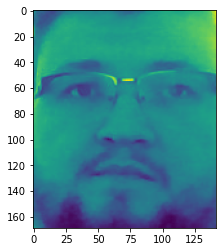

In [4]:
detector.run()

In [7]:
# MTCNN ожидаемо работает идеально

In [8]:
transforms = tt.Compose([tt.Grayscale(num_output_channels=1), 
                         tt.Resize((48, 48)),
                         tt.ToTensor()])

In [9]:
train_transforms = tt.Compose([tt.Grayscale(num_output_channels=1),
                         tt.RandomHorizontalFlip(),           
                         tt.RandomRotation(30),
                         tt.Resize((48, 48)),
                         tt.ToTensor()])

In [16]:
dataset = ImageFolder('C:/Users/79811/Videos/datasciense/pyTorch/data/', train_transforms)

In [17]:
dataset

Dataset ImageFolder
    Number of datapoints: 20000
    Root location: C:/Users/79811/Videos/datasciense/pyTorch/data/
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               Resize(size=(48, 48), interpolation=bilinear)
               ToTensor()
           )

In [18]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [19000,1000])

In [19]:
train_dataset

In [20]:
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle=True)

In [21]:
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False)

In [22]:
i = iter(train_dataset)

In [23]:
image, label = i.__next__()

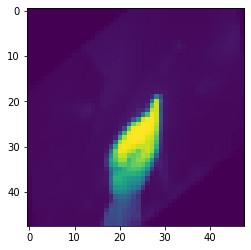

In [24]:
plt.imshow(image.permute((1,2,0)).reshape((48, 48)))

In [25]:
label

7

In [26]:
# ResNet реализация с вебинара

In [27]:
class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = self.conv_block(in_channels, 128)
        self.conv2 = self.conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(self.conv_block(128, 128), self.conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = self.conv_block(128, 256)
        self.conv4 = self.conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(self.conv_block(256, 256), self.conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = self.conv_block(256, 512)
        self.conv6 = self.conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(self.conv_block(512, 512), self.conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes),
                                        nn.Softmax(dim=1))
    
    @staticmethod
    def conv_block(in_channels, out_channels, pool=False):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
                  nn.BatchNorm2d(out_channels), 
                  nn.ELU(inplace=True)]
        if pool: layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        out = self.classifier(out)
        return out

In [28]:
resnet = ResNet(1, 10)

In [29]:
resnet

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [51]:
epochs = 6
max_lr = 0.0001
grad_clip = 0.1
weight_decay = 1e-4
optimizer = torch.optim.Adam(resnet.parameters(), max_lr)

In [52]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))

In [53]:
epoch_losses = []
true_y = []
pred_y = []

sm=nn.Softmax(dim=0)

for epoch in range(epochs):
    
    time1 = time.time()
    running_loss = 0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_loader):   
        
        optimizer.zero_grad()
        
        outputs = resnet(data)
        
        _, preds = torch.max(outputs, 1)
        
        true_y.append(labels)
        pred_y.append(outputs)
        
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        if (batch_idx+1) % 10000 == 9999:
            print(f'Train Epoch: {epoch+1}, Loss: {running_loss/10000}')
            time2 = time.time()
            print(f'Spend time for 10000 images: {time2 - time1} sec')
            time1 = time.time()
            running_loss = 0.0
    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss))
    epoch_losses.append(epoch_loss)


Epoch 1, loss:  1.4825355312238238
Epoch 2, loss:  1.49992514118201
Epoch 3, loss:  1.4838460651712386
Epoch 4, loss:  1.4760161339233218
Epoch 5, loss:  1.4711745375334615
Epoch 6, loss:  1.4705729390234257


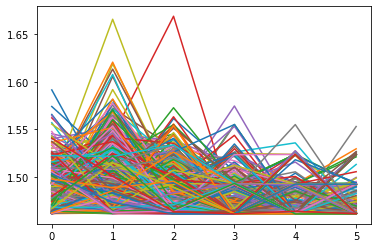

In [54]:
plt.plot(range(len(epoch_losses)), epoch_losses)
plt.draw()

In [55]:
i = iter(test_loader)

In [56]:
image, label = i.__next__()

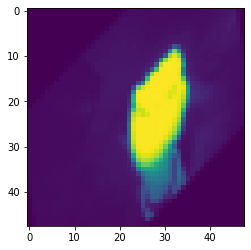

In [57]:
plt.imshow(image[0].permute((1,2,0)).reshape((48, 48)))

In [58]:
image.shape

torch.Size([1, 1, 48, 48])

In [59]:
np.array(label)[0]

0

In [60]:
np.argmax(np.array(resnet(image).detach()))

0

In [61]:
# Отлично - совпадает

9


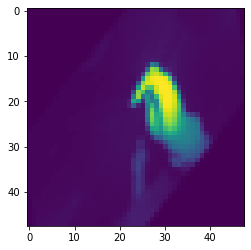

In [62]:
image, label = i.__next__()
plt.imshow(image[0].permute((1,2,0)).reshape((48, 48)))
print(np.array(label)[0])

In [63]:
np.argmax(np.array(resnet(image).detach()))

9

In [64]:
# Тут тоже 9 - 9

8


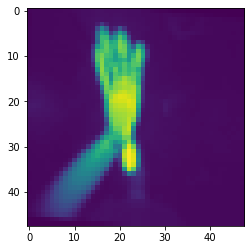

In [65]:
image, label = i.__next__()
plt.imshow(image[0].permute((1,2,0)).reshape((48, 48)))
print(np.array(label)[0])

In [66]:
np.argmax(np.array(resnet(image).detach()))

8

In [379]:
# 8 - 8

In [ ]:
# Пока угадывает. Осталось понять как он будет это делать на фотографиях с вебкамеры
# Проблема в том, что тренировались мы на IR фото, они достаточно сильно отличаются от обычной фотографии
# Насколько я понимаю depth картинки - это затухание яркости в глубину (по мере удаления от камеры)
# Получить такие "глубинные" фото можно с помощью немного специального устройства (эти были с LeapMotion)
# Из бытовых-более менее доступных - это Microsoft Kinekt, либо как-то научиться получать их с depth сенсора 


In [345]:
cap = cv2.VideoCapture(0)

In [346]:
ret, frame = cap.read()

In [347]:
cap.release()

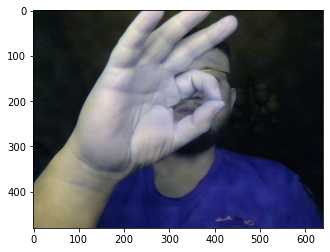

In [351]:
plt.imshow(frame)

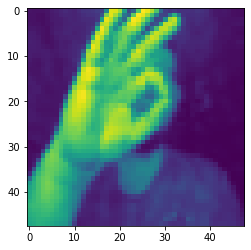

In [352]:
image = transforms(Image.fromarray(frame))
plt.imshow(image.permute(1, 2, 0).reshape((48, 48)))

In [353]:
# Шансов мне кажется - никаких
np.argmax(np.array(resnet(image.unsqueeze(0)).detach()))

6

In [148]:
#6-6 = получилось, но не с первого раза

In [149]:
# Возможно, чтобы хоть как-то приблизиться по картинке можно убрать фон (яркой фротнальной подсветкой от камеры)
# Опять-же - фронтальная подсветка в каком-то виде будет имитировать depth снимки - ближние объекты будут ярче
# Хоть это уже делает процесс съемки сложным, не подходящим для массового использования

In [308]:
cap = cv2.VideoCapture(0)

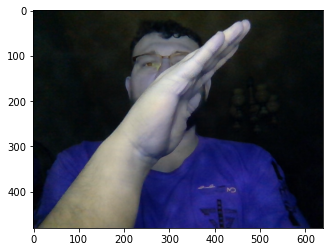

In [309]:
ret, frame2 = cap.read()
cap.release()
plt.imshow(frame2)

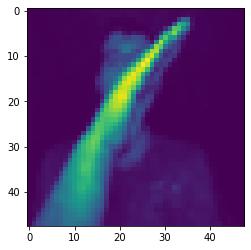

In [310]:
image2 = transforms(Image.fromarray((((frame2/255.0)**2)*255).astype(np.uint8)))
plt.imshow(image2.permute(1, 2, 0).reshape((48, 48)))

In [311]:
np.argmax(np.array(resnet(image2.unsqueeze(0)).detach()))

8

In [199]:
#8-8= получилось, но опять же не с первого разща

In [378]:
cap = cv2.VideoCapture(0)

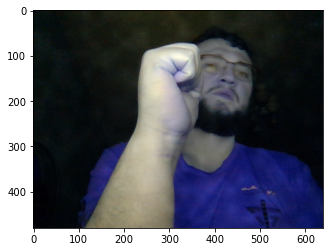

In [379]:
ret, frame3 = cap.read()
cap.release()
plt.imshow(frame3)

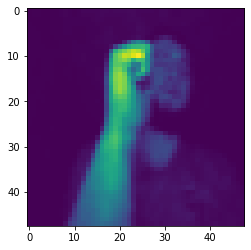

In [380]:
image3 = transforms(Image.fromarray((((frame3/255.0)**2)*255).astype(np.uint8)))
plt.imshow(image3.permute(1, 2, 0).reshape((48, 48)))

In [381]:
np.argmax(np.array(resnet(image3.unsqueeze(0)).detach()))

4

In [ ]:
# 4-4 = получилось н

In [470]:
cap = cv2.VideoCapture(0)

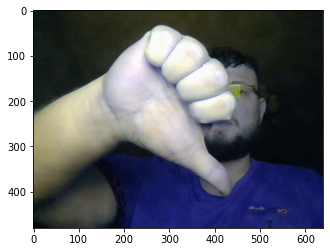

In [471]:
ret, frame4 = cap.read()
cap.release()
plt.imshow(frame4)

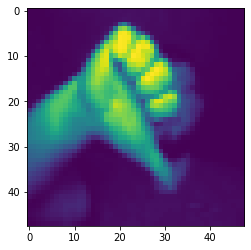

In [472]:
image4 = transforms(Image.fromarray((((frame4/255.0)**2)*255).astype(np.uint8)))
plt.imshow(image4.permute(1, 2, 0).reshape((48, 48)))

In [473]:
np.argmax(np.array(resnet(image4.unsqueeze(0)).detach()))

5

In [479]:
# Этот угадан тожевидимо надо запустить эпох на 100 (но по времени это огромнвый ресурс и надо больше искаженных данных, запишем саму функцию выполнения действия при распозновании)

In [475]:
class Detector():
    def __init__(self, mtcnn, detector, target_gesture=6):
        self.mtcnn = mtcnn
        self.detector = detector
        self.target = target_gesture
        
    
    def run(self):
        
        # Face detection loop
        cap = cv2.VideoCapture(0)

        while True:
            ret, frame = cap.read()
            
            if not ret:
                break
                
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            
            boxes, probs = self.mtcnn.detect(frame, landmarks=False)
            if boxes is not None and len(boxes) > 0:
                cropped = gray[int(boxes[0][1]):int(boxes[0][3]), int(boxes[0][0]):int(boxes[0][2])]
            
            if probs is not None and len(probs) > 0 and probs[0] is not None and probs[0] > 0.98:
                print('Face Detected')
                plt.imshow(cropped)
                cap.release()
                cv2.destroyAllWindows()
                break
            
            cv2.imshow('frame', gray)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                cap.release()
                cv2.destroyAllWindows()
                break
        
        if detector:
            # Gesture recognition loop
            cap = cv2.VideoCapture(0)

            while True:

                _, frame = cap.read()
                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                
                image = transforms(Image.fromarray((((frame/255.0)**2)*255).astype(np.uint8)))
                pred = np.argmax(np.array(resnet(image.unsqueeze(0)).detach()))
                print(pred)
                
                if pred == self.target:
                    plt.imshow(frame)
                    print('The symbol is recognized! Have a nice day..')
                    break
                
                cv2.imshow('frame', gray)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
                
        cap.release()
        cv2.destroyAllWindows()        
            

In [476]:
detector = Detector(MTCNN(), resnet, target_gesture=6)

Face Detected
9
0
9
9
9
9
9
9
5
9
9
0
0
8
0
5
5
4
5
9
0
5
5
5
5
4
4
6
The symbol is recognized! Have a nice day..


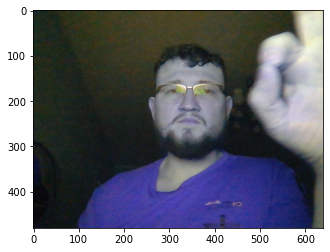

In [477]:
detector.run()

In [561]:
detector = Detector(MTCNN(), resnet, target_gesture=6)

Face Detected
9
8
0
8
9
9
0
8
0
9
9
9
9
9
4
4
4
9
8
5
4
6
The symbol is recognized! Have a nice day..


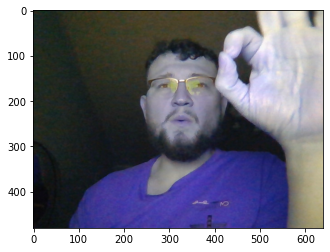

In [478]:
detector.run()